### Setup

In [77]:
import pandas as pd
import numpy as np
from getpass import getpass
from mysql.connector import connect, Error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
import matplotlib.pyplot as plt

In [2]:
# Load Password
pwd = getpass()

········


In [3]:
pd.set_option('display.max_rows', 100)

### Load in tables / format

In [4]:
conn = connect(
      user = 'root',
      password = pwd,
      host = 'localhost',
      database = 'world_happiness')
 
print('A connection object has been created.')

scores_sql = 'SELECT * FROM world_happiness_data;'
happiness_scores= pd.read_sql(scores_sql, con = conn)

sql_2015 = 'SELECT * FROM full_report_2015'
full_report_2015 = pd.read_sql(sql_2015, con = conn)

sql_2016 = 'SELECT * FROM full_report_2016'
full_report_2016 = pd.read_sql(sql_2016, con = conn)

sql_2017 = 'SELECT * FROM full_report_2017'
full_report_2017 = pd.read_sql(sql_2017, con = conn)

sql_2018 = 'SELECT * FROM full_report_2018'
full_report_2018 = pd.read_sql(sql_2018, con = conn)

sql_2019 = 'SELECT * FROM full_report_2019'
full_report_2019 = pd.read_sql(sql_2019, con = conn)

conn.close()
print('The connection has been closed')

A connection object has been created.
The connection has been closed


/var/folders/2t/vtgh7f0x5ns5m6x9psdw8y7m0000gn/T/ipykernel_42756/2153304734.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  happiness_scores= pd.read_sql(scores_sql, con = conn)
/var/folders/2t/vtgh7f0x5ns5m6x9psdw8y7m0000gn/T/ipykernel_42756/2153304734.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  full_report_2015 = pd.read_sql(sql_2015, con = conn)
/var/folders/2t/vtgh7f0x5ns5m6x9psdw8y7m0000gn/T/ipykernel_42756/2153304734.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  full_report_2016 = pd.read_sql(sql_

In [5]:
# Add year column to individual reports
full_report_2015.loc[:, 'Year'] = 2015
full_report_2016.loc[:, 'Year'] = 2016
full_report_2017.loc[:, 'Year'] = 2017
full_report_2018.loc[:, 'Year'] = 2018
full_report_2019.loc[:, 'Year'] = 2019

# Convert Country Name and Region columns to title case (Region only exists in 2015 / 2016 data)
full_report_2015.loc[:, 'Country'] = full_report_2015.loc[:, 'Country'].str.title()
full_report_2016.loc[:, 'Country'] = full_report_2016.loc[:, 'Country'].str.title()
full_report_2017.loc[:, 'Country'] = full_report_2017.loc[:, 'Country'].str.title()
full_report_2018.loc[:, 'Country'] = full_report_2018.loc[:, 'Country'].str.title()
full_report_2019.loc[:, 'Country'] = full_report_2019.loc[:, 'Country'].str.title()

full_report_2015.loc[:, 'Region'] = full_report_2015.loc[:, 'Region'].str.title()
full_report_2016.loc[:, 'Region'] = full_report_2016.loc[:, 'Region'].str.title()

happiness_scores.loc[:, 'Country'] = happiness_scores.loc[:, 'Country'].str.title()

In [6]:
# Union all the reports year / country
comb_reports = pd.concat([full_report_2015[['Country', 'Year']], full_report_2016[['Country', 'Year']], 
                          full_report_2017[['Country', 'Year']], full_report_2018[['Country', 'Year']],
                          full_report_2019[['Country', 'Year']]], axis = 0)

comb_reports.shape

(781, 2)

### Coverage of full report data

In [7]:
# Observere how many countries have coverage for each year - vast majority have all 5 years
comb_reports.groupby('Country').agg({'Year': 'count'}) \
    .reset_index() \
    .groupby('Year').agg({'Country': 'count'})

,Country
Year,
1,7
2,5
3,4
4,13
5,140


### Is country to region mapping consistent in 2015 and 2016

In [8]:
# Observe differences in region mapping between 2015 and 2016 (only diffs are from diff countries)
region_map = pd.merge(full_report_2015[['Country', 'Region']], full_report_2016[['Country', 'Region']],
         how = 'outer', on = 'Country', suffixes = ('_2015', '_2016'))

diff_msk = region_map['Region_2015'] != region_map['Region_2016']
same_msk = region_map['Region_2015'] == region_map['Region_2016']
region_map[diff_msk]

,Country,Region_2015,Region_2016
25,Central African Republic,Sub-Saharan Africa,NaN
38,Djibouti,Sub-Saharan Africa,NaN
78,Lesotho,Sub-Saharan Africa,NaN
96,Mozambique,Sub-Saharan Africa,NaN
106,Oman,Middle East And Northern Africa,NaN
133,Swaziland,Sub-Saharan Africa,NaN
158,Belize,NaN,Latin America And Caribbean
159,Namibia,NaN,Sub-Saharan Africa
160,Puerto Rico,NaN,Latin America And Caribbean
161,Somalia,NaN,Sub-Saharan Africa


In [9]:
region_map[same_msk].shape

(152, 3)

### Since only diff between 2015 and 2016 are from different countries, we can just UNION to create mapping

In [10]:
country_region_map = pd.concat([full_report_2015[['Country', 'Region']],
                                full_report_2016[['Country', 'Region']]], axis = 0)
country_region_map = country_region_map.drop_duplicates().copy()
assert country_region_map.shape[0] == region_map[same_msk].shape[0] + region_map[diff_msk].shape[0]

country_region_map

,Country,Region
0,Afghanistan,Southern Asia
1,Albania,Central And Eastern Europe
2,Algeria,Middle East And Northern Africa
3,Angola,Sub-Saharan Africa
4,Argentina,Latin America And Caribbean
...,...,...
13,Belize,Latin America And Caribbean
95,Namibia,Sub-Saharan Africa
112,Puerto Rico,Latin America And Caribbean
124,Somalia,Sub-Saharan Africa


### Add country region / map to happiness scores / data

In [11]:
# Add region to hapiness_scores
df_happiness = pd.merge(happiness_scores, country_region_map, how = 'left', on = 'Country').copy()
print(df_happiness.shape)
df_happiness.head()

(1523, 5)


,Country,Year,HappinessIndex,HappinessRank,Region
0,Afghanistan,2013,4.040,143,Southern Asia
1,Afghanistan,2015,3.575,153,Southern Asia
2,Afghanistan,2016,3.360,154,Southern Asia
3,Afghanistan,2017,3.794,141,Southern Asia
4,Afghanistan,2018,3.632,145,Southern Asia


### Get common attributes from each full report table, and join them with df_happiness

In [12]:
com_attrs = ['Country', 'Economy', 'Family', 'Health', 'Freedom', 'Trust', 'Generosity', 'Year']

In [13]:
# Combine all data with full score breakdown
all_score_breakdown = \
    pd.concat([full_report_2015[com_attrs], full_report_2016[com_attrs], full_report_2017[com_attrs],
           full_report_2018[com_attrs], full_report_2019[com_attrs]], axis = 0).copy()

all_score_breakdown.shape

(781, 8)

In [14]:
df_comb = pd.merge(df_happiness, all_score_breakdown, how = 'left', on = ['Country', 'Year']).copy()
print(df_comb.shape)
df_comb.head()

(1523, 11)


,Country,Year,HappinessIndex,HappinessRank,Region,Economy,Family,Health,Freedom,Trust,Generosity
0,Afghanistan,2013,4.040,143,Southern Asia,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2015,3.575,153,Southern Asia,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100
2,Afghanistan,2016,3.360,154,Southern Asia,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680
3,Afghanistan,2017,3.794,141,Southern Asia,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871
4,Afghanistan,2018,3.632,145,Southern Asia,0.332000,0.537000,0.255000,0.08500,0.036000,0.191000


### EDA

In [15]:
# Create mask to just look at 2015 / 2019 data
msk_2015_2019 = df_comb['Year'].isin([2015, 2016, 2017, 2018, 2019])
df_comb[msk_2015_2019].shape

(782, 11)

In [16]:
analysis_features = ['HappinessIndex', 'Economy', 'Family', 'Health', 'Freedom', 'Trust', 'Generosity']

corr = df_comb.loc[msk_2015_2019, analysis_features].corr(numeric_only = True)
corr.style.background_gradient(cmap='coolwarm')

,HappinessIndex,Economy,Family,Health,Freedom,Trust,Generosity
HappinessIndex,1.000000,0.792977,0.651855,0.742992,0.553655,0.413948,0.146624
Economy,0.792977,1.000000,0.599915,0.784710,0.340900,0.326039,0.000293
Family,0.651855,0.599915,1.000000,0.574557,0.426095,0.140650,-0.032133
Health,0.742992,0.784710,0.574557,1.000000,0.342476,0.260551,0.020135
Freedom,0.553655,0.340900,0.426095,0.342476,1.000000,0.468655,0.292160
Trust,0.413948,0.326039,0.140650,0.260551,0.468655,1.000000,0.302701
Generosity,0.146624,0.000293,-0.032133,0.020135,0.292160,0.302701,1.000000


### Run regresson of factors against HappinessIndex score

In [17]:
reg_df = df_comb.loc[msk_2015_2019, analysis_features + ['Country', 'Region', 'Year']].copy()
print(reg_df.shape)
reg_df.head()

(782, 10)


,HappinessIndex,Economy,Family,Health,Freedom,Trust,Generosity,Country,Region,Year
1,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100,Afghanistan,Southern Asia,2015
2,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680,Afghanistan,Southern Asia,2016
3,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871,Afghanistan,Southern Asia,2017
4,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,0.191000,Afghanistan,Southern Asia,2018
5,3.203,0.350000,0.517000,0.361000,0.00000,0.025000,0.158000,Afghanistan,Southern Asia,2019


In [18]:
# Drop these observations out for the model
print(reg_df.isna().sum())
reg_df = reg_df.dropna().copy()
print(reg_df.isna().sum())

HappinessIndex     0
Economy           38
Family            38
Health            38
Freedom           38
Trust             38
Generosity        38
Country            0
Region            33
Year               0
dtype: int64
HappinessIndex    0
Economy           0
Family            0
Health            0
Freedom           0
Trust             0
Generosity        0
Country           0
Region            0
Year              0
dtype: int64


In [19]:
# Apply standard scaler to scale dependent variables
feats_to_scale = ['Economy', 'Family', 'Health', 'Freedom', 'Trust', 'Generosity']
X_scale = reg_df.filter(feats_to_scale).copy()
print(X_scale.head())
scaler = StandardScaler()
scaler.fit(X_scale)
X = scaler.transform(X_scale)
y = np.array(reg_df['HappinessIndex'].copy())
X.shape, y.shape

    Economy    Family    Health  Freedom     Trust  Generosity
1  0.319820  0.302850  0.303350  0.23414  0.097190    0.365100
2  0.382270  0.110370  0.173440  0.16430  0.071120    0.312680
3  0.401477  0.581543  0.180747  0.10618  0.061158    0.311871
4  0.332000  0.537000  0.255000  0.08500  0.036000    0.191000
5  0.350000  0.517000  0.361000  0.00000  0.025000    0.158000


((742, 6), (742,))

In [25]:
# Add standardized features to regression df
for ii in range(X.shape[1]):
    col_name = feats_to_scale[ii] + '_scale'
    reg_df.loc[:, col_name] = X[:, ii]

Text(0.5, 1.0, 'Predicted vs Actual Happiness Score')

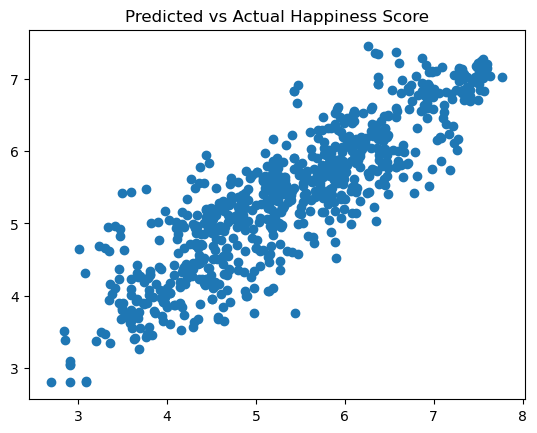

In [60]:
# Scatter of predicted vs actuals
plt.scatter(x = reg_df['HappinessIndex'], y = model.predict(X))
plt.title('Predicted vs Actual Happiness Score')

In [26]:
# Model coefficients and intercept
model = LinearRegression().fit(X, y)
model.coef_, model.intercept_,

(array([0.47370225, 0.2045226 , 0.25385208, 0.23145314, 0.09170317,
        0.07306824]),
 5.385169811320755)

In [82]:
# R^2 of the model (high R^2 of 77%)
r2_score(y_pred = model.predict(X), y_true = reg_df['HappinessIndex'])

0.7665503285433029

In [27]:
# Create map between coefficients and feature names
feature_coef_map = dict(zip(feats_to_scale, model.coef_))

In [90]:
feature_coef_map

{'Economy': 0.4737022547157193,
 'Family': 0.20452259583214621,
 'Health': 0.25385208318969366,
 'Freedom': 0.23145314450489304,
 'Trust': 0.09170316938333468,
 'Generosity': 0.07306824438842055}

In [28]:
# Add predicted scores and residuals
reg_df.loc[:, 'PredictedIndex'] = model.predict(X)
reg_df.loc[:, 'Resid'] = reg_df['HappinessIndex'] - reg_df['PredictedIndex']

<Axes: >

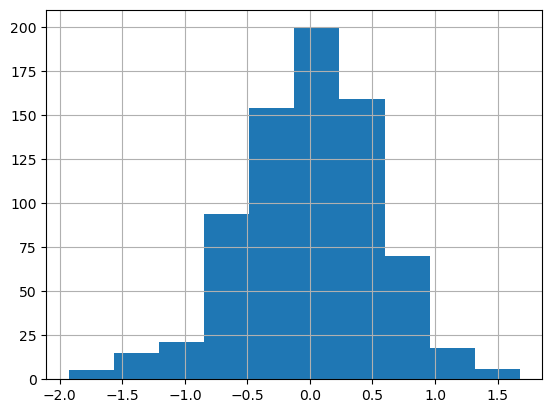

In [29]:
# Plot residuals
reg_df.Resid.hist()

### Add Attribution + Check that it is working

In [30]:
# Calculate effect size of each feature per country / time period
for feat in feats_to_scale:
    coef = feature_coef_map[feat]
    reg_df.loc[:, f'{feat}_contribution'] = reg_df.loc[:, f'{feat}_scale'] * coef

In [75]:
# Check that feature scaling is working
example_feat = 'Generosity'
example_coef = feature_coef_map[example_feat]
example_feat = reg_df.loc[:, example_feat].copy()
example_feat_scale = reg_df.loc[:, f'{feat}_scale'].copy()
example_feat_cont = reg_df.loc[:, f'{feat}_scale'].copy() * coef
feat_comp = pd.concat([example_feat, example_feat_scale, example_feat_cont], axis = 1)
print(feat_comp)

      Generosity  Generosity_scale  Generosity_scale
1       0.365100          1.175638          0.085902
2       0.312680          0.748028          0.054657
3       0.311871          0.741429          0.054175
4       0.191000         -0.244561         -0.017870
5       0.158000         -0.513755         -0.037539
...          ...               ...               ...
1514    0.189870         -0.253779         -0.018543
1515    0.185030         -0.293261         -0.021428
1516    0.189143         -0.259709         -0.018977
1517    0.132000         -0.725846         -0.053036
1518    0.151000         -0.570856         -0.041711

[742 rows x 3 columns]


In [35]:
cont_features = ['Economy_contribution', 'Family_contribution', 'Health_contribution', 'Freedom_contribution',
                   'Trust_contribution', 'Generosity_contribution', 'Resid']
cont_features

['Economy_contribution',
 'Family_contribution',
 'Health_contribution',
 'Freedom_contribution',
 'Trust_contribution',
 'Generosity_contribution',
 'Resid']

In [74]:
# The intercept of the regression model is just equal to the average happiness score
model.intercept_ == reg_df['HappinessIndex'].mean()

True

In [72]:
# Check that calc scores are the same as actual scores
calc_pred = reg_df[cont_features].sum(axis = 1) +  5.385169811320755
score_comp = pd.concat([calc_pred, reg_df['HappinessIndex']], axis = 1)
score_comp.columns = ['Calculated Score', 'Happiness Index']
assert np.where(abs(score_comp['Calculated Score'] - score_comp['Happiness Index']) >= .00001)
score_comp

,Calculated Score,Happiness Index
1,3.575,3.575
2,3.360,3.360
3,3.794,3.794
4,3.632,3.632
5,3.203,3.203
...,...,...
1514,4.610,4.610
1515,4.193,4.193
1516,3.875,3.875
1517,3.692,3.692


In [85]:
# Add intercept to the dataframe for attribution of scores
reg_df.loc[:, 'Intercept'] = model.intercept_

### Write dataframe to CSV

In [276]:
# Get cwd
os.getcwd()

'/Users/kevincory/Documents/Graduate Classes/6289 - DB Mgmt Using Python/Project/Analysis'

In [87]:
# Write regression data to CSV
reg_df.to_csv('happiness_regression_data.csv')
print('wrote to csv')

wrote to csv
